In [1]:
from transformers import AutoTokenizer, AutoModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn import metrics
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [2]:
def encoding(model, tokenizer, sentences):
    model.eval()
    model.to(device)
    max_char_len = 128
    sents_inputs = tokenizer(sentences, return_tensors='pt', max_length=max_char_len, padding="max_length", truncation=True)
    input_ids = sents_inputs['input_ids']
    dataloader = DataLoader(input_ids, batch_size=128, shuffle=False)
    sents_vec = []
    tqdm_batch_iterator = tqdm(dataloader, desc='sentence encoding ')
    for index, batch in enumerate(tqdm_batch_iterator):
        input_ids = batch
        input_ids = input_ids.to(device)
        sents_vec.append(model(input_ids)['pooler_output'].detach().cpu().numpy().tolist())
    torch.cuda.empty_cache()
    sents_vec = [np.array(xi) for x in sents_vec for xi in x]
    return sents_vec

In [3]:
from config import *
df_train = preprocess_data(train_path)

In [4]:
df_train

,sentence,label
0,"12-11，停经51天，2天求HCG：133.69IU/L,要求终止妊娠，无腹痛无阴道出血",妊娠状态
1,患者反复咳嗽1周余，外院胸片提示右下肺炎,肺炎
2,自述既往缺铁性贫血，目前哺乳期，要求配药,缺铁性贫血
3,"右侧后枕部颈部抽痛半年,无恶心吐,无涕血.PE颈部软,右侧风池穴压痛,颞动脉无殊.颅底MRI...",枕大神经痛
4,月经紊乱13年。平素月经规则，周期30天，经期5-6天。2年前开始经期延长，15-20天。末次月经,月经失调
...,...,...
26578,"上腹不适,饥饿明显,腹胀,恶心,反酸,大便无黑便,稀烂,服PPI可,无肿瘤,体检无殊..",反流性食管炎
26579,自来，现状继续保持，但无继续进步，自行加药舍曲林150mgqd，丁螺环酮40mgqd，予医保...,抑郁症
26580,流涕喷嚏2天，少量咳嗽，无发热、咽痛咳痰。查体：咽略红，扁桃体不大。,急性上呼吸道感染
26581,双眼睑红斑少许脱屑瘙痒2天。,神经性皮炎


In [5]:
from config import model
tokenizer = AutoTokenizer.from_pretrained(model)
auto_model = AutoModel.from_pretrained(model)

Some weights of the model checkpoint at /mnt/hdd3/hanrui/bert/result were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
sents_vec = encoding(auto_model , tokenizer, df_train.sentence.to_list())

sentence encoding : 100%|██████████| 208/208 [00:40<00:00,  5.14it/s]


In [7]:
bert_features = np.array(sents_vec)




In [8]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA



In [9]:
def dimension_reduction(n_components,method,bert_features):
    X  = method(n_components).fit_transform(bert_features)
    return X

In [10]:
X_tsne_2d  = dimension_reduction(2,TSNE,bert_features)
X_PCA_2d = dimension_reduction(2,PCA,bert_features)

/home/hanrui/.conda/envs/shihanrui/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/hanrui/.conda/envs/shihanrui/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [11]:
# X_tsne_2d[0]
df_tsne = pd.concat([pd.DataFrame(X_tsne_2d),df_train.label],axis=1)



In [12]:
from config import reverse_labels
label_dict_reverse = reverse_labels(label_path)
df_tsne.label = df_tsne.label.map(label_dict_reverse)

In [13]:
df = df_tsne[[0,1,'label']][(df_tsne.label == 1) | (df_tsne.label == 0)] 

In [14]:
df

,0,1,label
0,56.076836,-21.320314,1
12,49.636742,-15.696952,1
13,44.029388,-57.897144,1
19,4.603806,49.707451,1
34,35.805462,4.013864,0
...,...,...,...
26553,42.242081,-59.586155,1
26562,32.344357,44.052647,0
26575,-25.931818,-64.480553,0
26580,-20.849062,-48.655704,0


Text(0.5, 1.0, 't-SNE')

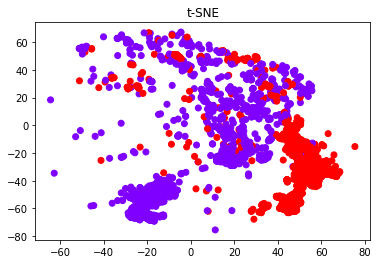

In [15]:
import matplotlib.pyplot as plt
plt.scatter(df[0],df[1],c=df['label'],cmap='rainbow')
plt.title('t-SNE')


In [19]:
df_PCA = pd.concat([pd.DataFrame(X_PCA_2d),df_train.label],axis=1)
label_dict_reverse = reverse_labels(label_path)
df_PCA.label = df_PCA.label.map(label_dict_reverse)
df = df_PCA[[0,1,'label']][(df_PCA.label == 1) | (df_PCA.label == 0)] 

Text(0.5, 1.0, 'PCA')

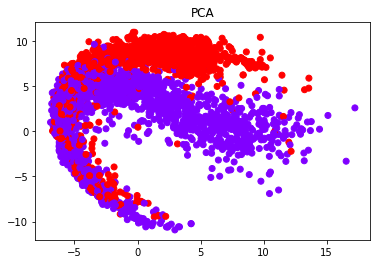

In [20]:
plt.scatter(df[0],df[1],c=df['label'],cmap='rainbow')
plt.title('PCA')